In [1]:
%matplotlib inline

import pyspark.sql.functions as F
import pyspark.sql.types as T
import graphframes as GF
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

spark = SparkSession\
        .builder\
        .appName("AirportGraphAnalysis")\
        .getOrCreate()

In [2]:
on_time_df = spark.read.parquet('qfs:///data/airline/processed/airline_data')
airport_codes_df = spark.read.parquet('qfs:///data/airline/processed/airport_id_table')
airline_ids_df = spark.read.parquet('qfs:///data/airline/processed/DOT_airline_codes_table')

In [3]:
airport_vertices = (
    airport_codes_df
    .withColumnRenamed('AirportID','id')
    .withColumnRenamed('Name','name')
    .select('id','name','City')
)

airport_edges = (
    on_time_df
    .select(
        F.col('OriginAirportID').alias('src'),
        F.col('DestAirportID').alias('dst'),
        'AirlineID',
        F.format_string('%d-%02d',F.col('Year'),F.col('Month')).alias('YearMonth')
    )
    .join(
        airline_ids_df.select('AirlineID','AirlineName'),
        on='AirlineID',
        how='inner'
    )
    .drop('AirlineID')
).cache()


# create GraphFrame
graph = GF.GraphFrame(airport_vertices, airport_edges)

graph

GraphFrame(v:[id: int, name: string ... 1 more field], e:[src: int, dst: int ... 2 more fields])

In [4]:
# calculate the overall "pagerank" of the airports across all the data, display top 20

overall_ranks = graph.pageRank(resetProbability=0.01, maxIter=20)

(
    overall_ranks.vertices
    .orderBy("pagerank", ascending=False)
).limit(20).toPandas()

,id,name,City,pagerank
0,10397,Hartsfield-Jackson Atlanta International,"Atlanta, GA",326.211559
1,13930,Chicago O'Hare International,"Chicago, IL",287.742369
2,11298,Dallas/Fort Worth International,"Dallas/Fort Worth, TX",245.531416
3,12892,Los Angeles International,"Los Angeles, CA",191.200115
4,11292,Denver International,"Denver, CO",178.852588
5,14107,Phoenix Sky Harbor International,"Phoenix, AZ",159.152823
6,12266,George Bush Intercontinental/Houston,"Houston, TX",149.647836
7,12889,McCarran International,"Las Vegas, NV",132.304597
8,14771,San Francisco International,"San Francisco, CA",129.775437
9,11433,Detroit Metro Wayne County,"Detroit, MI",124.944428


In [5]:
# calculate the monthly "pageranks" of the airports. Normalize all scores so that
# top ranks airport has a score of 1.0, and all other scores are proportional to that.

month_set = [r.YearMonth for r in airport_edges.select('YearMonth').distinct().collect()]

monthly_ranks_list = [
    (
        graph
        .filterEdges('YearMonth = "{0}"'.format(m))
        .pageRank(resetProbability=0.01, maxIter=20)
        .vertices
        .withColumn('YearMonth',F.lit(m).cast(T.StringType()))
    ) for m in month_set
]

monthly_ranks = None

for cur_month_ranks in monthly_ranks_list:
    maxRank = cur_month_ranks.agg(F.max('pagerank').alias('maxRank')).collect()[0].maxRank
    normalized_ranks = cur_month_ranks.withColumn('normalized_rank', F.col('pagerank')/maxRank)
    if monthly_ranks is None:
        monthly_ranks = normalized_ranks
    else:
        monthly_ranks = monthly_ranks.union(normalized_ranks)
monthly_ranks = monthly_ranks.cache()

In [6]:
#
# save the monthly airport pagerank data to disk so that analysis can be revisted later without
# having to recalculate from the beginning (which takes a while).
#

overall_ranks.vertices.repartition(3).write.parquet('qfs:///data/airline/analysis/overall_airport_pageranks', mode='overwrite')
monthly_ranks.repartition(12).write.parquet('qfs:///data/airline/analysis/monthly_airport_pageranks', mode='overwrite')

In [7]:
# load saved calculated airport pagerank data and analyze for top N airports

top_airport_count = 15

top_airports = (
    spark.read.parquet('qfs:///data/airline/analysis/overall_airport_pageranks')
    .orderBy("pagerank", ascending=False)
    .limit(top_airport_count)
    .coalesce(1)
)

monthly_ranks_top = (
    spark.read.parquet('qfs:///data/airline/analysis/monthly_airport_pageranks')
    .join(
        F.broadcast(top_airports.select('id')),
        on='id',
        how='inner'
    )
)

airport_set = [(r.name, r.City) for r in top_airports.select('name','City').collect()]

airport_set

[('Hartsfield-Jackson Atlanta International', 'Atlanta, GA'),
 ("Chicago O'Hare International", 'Chicago, IL'),
 ('Dallas/Fort Worth International', 'Dallas/Fort Worth, TX'),
 ('Los Angeles International', 'Los Angeles, CA'),
 ('Denver International', 'Denver, CO'),
 ('Phoenix Sky Harbor International', 'Phoenix, AZ'),
 ('George Bush Intercontinental/Houston', 'Houston, TX'),
 ('McCarran International', 'Las Vegas, NV'),
 ('San Francisco International', 'San Francisco, CA'),
 ('Detroit Metro Wayne County', 'Detroit, MI'),
 ('Minneapolis-St Paul International', 'Minneapolis, MN'),
 ('Newark Liberty International', 'Newark, NJ'),
 ('Charlotte Douglas International', 'Charlotte, NC'),
 ('Logan International', 'Boston, MA'),
 ('Salt Lake City International', 'Salt Lake City, UT')]

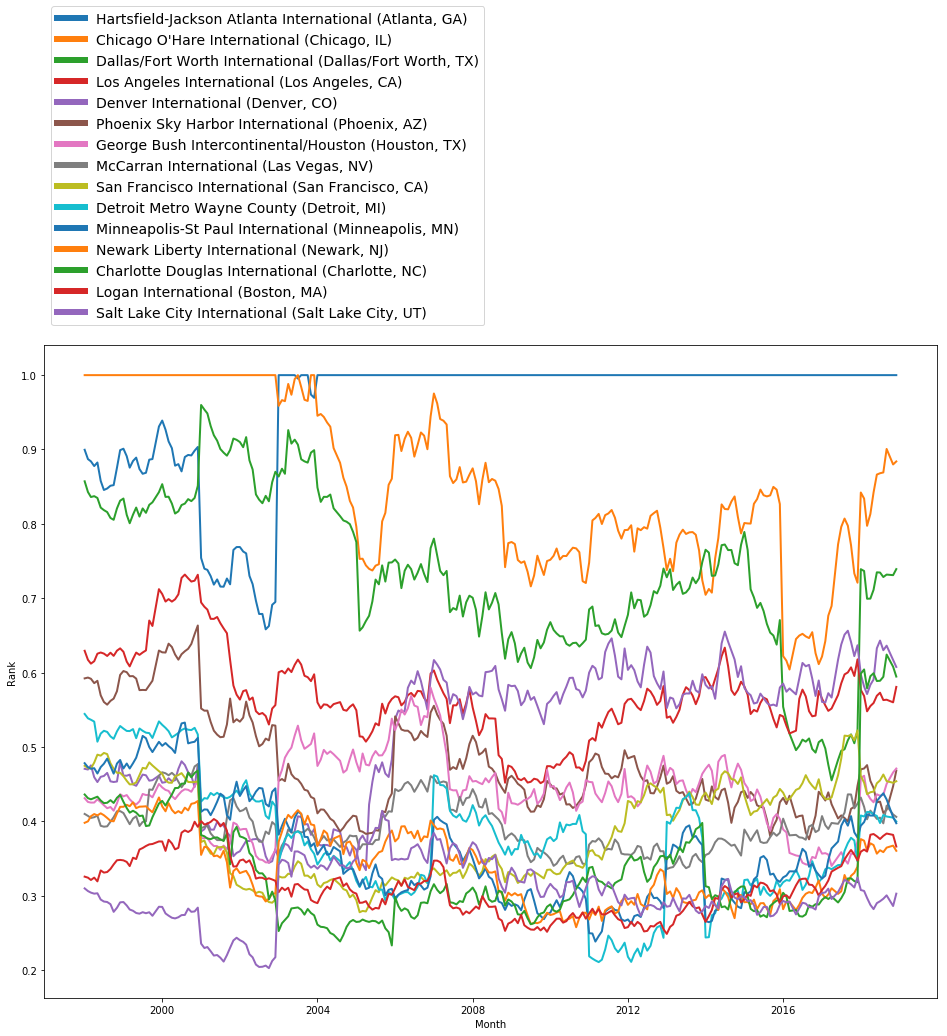

In [8]:
# graph the monthly airport normalized pageranks

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

monthly_ranks_top_pd = monthly_ranks_top.orderBy('YearMonth').toPandas()

fig, ax = plt.subplots()

for airport in airport_set:
    rank_data = monthly_ranks_top_pd[monthly_ranks_top_pd['City'] == airport[1]]
    dates_raw = rank_data['YearMonth']
    dates = [dt.datetime.strptime(date,'%Y-%m') for date in dates_raw]
    ax.plot(
        dates,
        rank_data['normalized_rank'],
        label = '{0} ({1})'.format(airport[0], airport[1]),
        linewidth = 2
    )
    
fig.set_size_inches(16,12)
plt.xlabel("Month")
plt.ylabel("Rank")
plt.setp(plt.legend(loc='lower left', prop={'size': 14}, bbox_to_anchor=(0,1.02,1,0.2)).get_lines(), linewidth=6)    
plt.show()